# Investigate poor SpecParam model fits

#### Imports

In [1]:
# auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import odml
from specparam import SpectralModel, SpectralGroupModel
from specparam.plts import plot_spectra

# custom
import sys
sys.path.append("../code")
from plots import plot_psd_diff
from paths import EXTERNAL_PATH
from info import SESSIONS, FS, N_ARRAYS
from settings import SPECPARAM_SETTINGS, N_JOBS

#### Settings

#### Functions

## Main

#### Create output directory

In [3]:
# dir_out = f"{PROJECT_PATH}/figures/"
# if not os.path.exists(dir_out):
#     os.makedirs(dir_out)

### Check out r-squared and error metrics

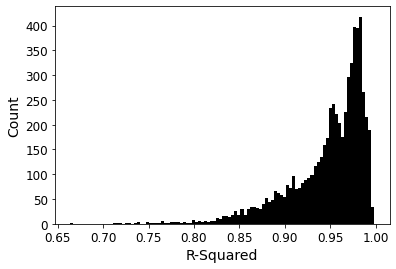

In [5]:
# load r-squared values
path = f"{EXTERNAL_PATH}/data/lfp/lfp_params"
files = os.listdir(path)
r_squared = []
for file in files:
    sgm = SpectralGroupModel()
    sgm.load(f"{path}/{file}")
    r_squared.append(sgm.get_params("r_squared"))
r_squared = np.array(r_squared)

# plot histogram
fig, ax = plt.subplots()
ax.hist(r_squared.flatten(), bins=100, color="black")
ax.set_xlabel("R-Squared")
ax.set_ylabel("Count")
plt.show()

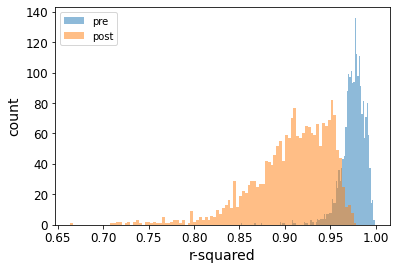

In [15]:
# plot r-squared for pre- and post seperately

sessions = ['A_SNR_041018', 'L_SNR_250717']
path = f"{EXTERNAL_PATH}/data/lfp/lfp_params"

# init fogure
fig, ax = plt.subplots()

# load r-suqared
r_squared = dict()
for epoch in ['pre', 'post']:
    r_squared[epoch] = []
    for session in sessions:
        # load r-squared values
        sgm = SpectralGroupModel()
        sgm.load(f"{path}/{session}_lfp_{epoch}.json")
        r_squared[epoch].append(sgm.get_params("r_squared"))
    r_squared[epoch] = np.concatenate(r_squared[epoch])

    # plot histogram
    ax.hist(r_squared[epoch], 100, alpha=0.5, label=epoch)

# label and show
ax.legend()
ax.set_xlabel("r-squared")
ax.set_ylabel("count")
plt.show()

Model fits have strikingly less error in the pre-stimulus window compared to the post-stimulus window.

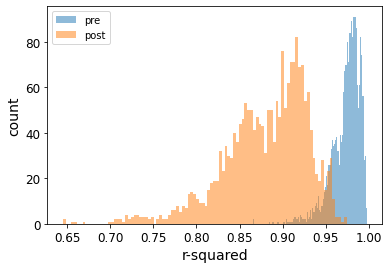

In [16]:
# plot r-squared for "fixed" model

sessions = ['A_SNR_041018', 'L_SNR_250717']
path = f"{EXTERNAL_PATH}/data/lfp/lfp_params"

# init fogure
fig, ax = plt.subplots()

# load r-suqared
r_squared = dict()
for epoch in ['pre', 'post']:
    r_squared[epoch] = []
    for session in sessions:
        # load r-squared values
        sgm = SpectralGroupModel()
        sgm.load(f"{path}/{session}_lfp_{epoch}.json")
        r_squared[epoch].append(sgm.get_params("r_squared"))
    r_squared[epoch] = np.concatenate(r_squared[epoch])

    # plot histogram
    ax.hist(r_squared[epoch], 100, alpha=0.5, label=epoch)

# label and show
ax.legend()
ax.set_xlabel("r-squared")
ax.set_ylabel("count")
plt.show()

Fits are worse with fixed model

#### Find worst fit

In [6]:
# load specparam results
sgm_pre = SpectralGroupModel()
sgm_post = SpectralGroupModel()
sgm_pre.load(f"{EXTERNAL_PATH}/data/lfp/lfp_params/{SESSIONS[0]}_lfp_pre.json")
sgm_post.load(f"{EXTERNAL_PATH}/data/lfp/lfp_params\{SESSIONS[0]}_lfp_post.json")

In [7]:
r_pre = sgm_pre.get_params('r_squared')
r_post = sgm_post.get_params('r_squared')

print("r_squaed pre values below 0.90:")
for i in r_pre :
    if i < 0.90 :
        print(i)

print("\n r_squaed post values below 0.90:")
for i in r_post :
    if i < 0.90 :
        print(i)

r_squaed pre values below 0.90:
0.8743804123444624
0.8956256913329002
0.8665738704555467

 r_squaed post values below 0.90:
0.8976656537134676
0.89415381278098
0.8965484897902477
0.8908237726253776
0.8906623851868104
0.8348844577144611
0.8385937058711266
0.8197192653305521
0.8527289171946586
0.85238812722747
0.8489129124826236
0.8423065371131506
0.7162025343553029
0.7582299282764308
0.7877689751879182
0.7977007547227326
0.7700156557200659
0.8387217628839863
0.8254073667827505
0.8349797230859038
0.8185004030922778
0.8328510999614984
0.8120421719040505
0.8733403680415732
0.7200766300425263
0.7398315693432922
0.7648975904886465
0.7257717940717466
0.7126836875546781
0.7167482537995254
0.7350647917745338
0.784480560879109
0.8072764417651908
0.7480902977994537
0.7387104009018796
0.7107918410615666
0.6636578974905663
0.8692681662236353
0.8784945528912413
0.854245870182174
0.8630176285895914
0.8643951864079731
0.848810117274477
0.8904924406897371
0.8518567138134114
0.7827454869579814
0.8865075

In [8]:
# get indices of low r_squared values
low_r_squared = np.argwhere(r_pre < 0.9).flatten()
low_r_squared

array([135, 151, 159], dtype=int64)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 4 - 100 Hz                        
                                 Frequency Resolution is 0.76 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     5.8418, -1.6197, 1.6308                                      
                                                                                                  
                                       1 peaks were found:                                        
          

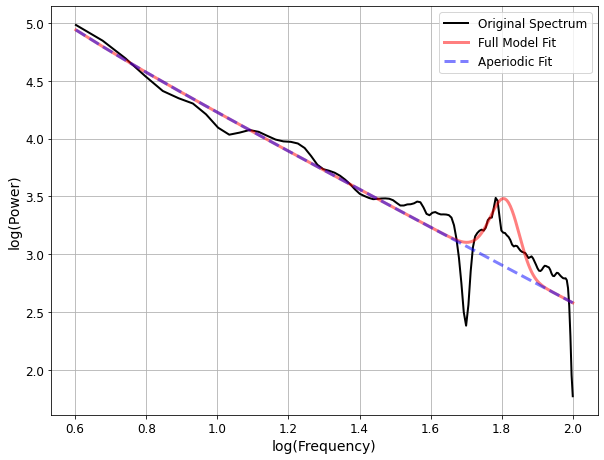

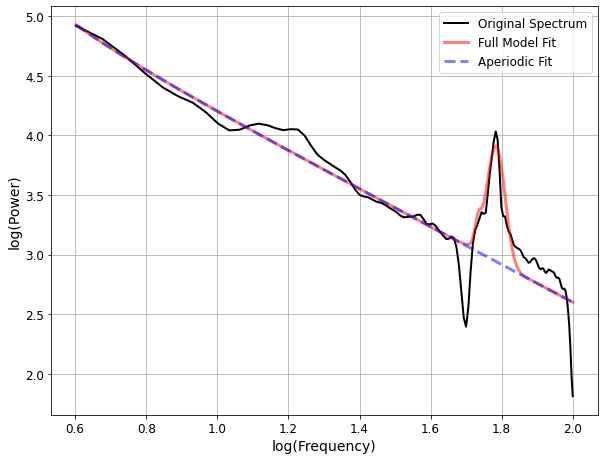

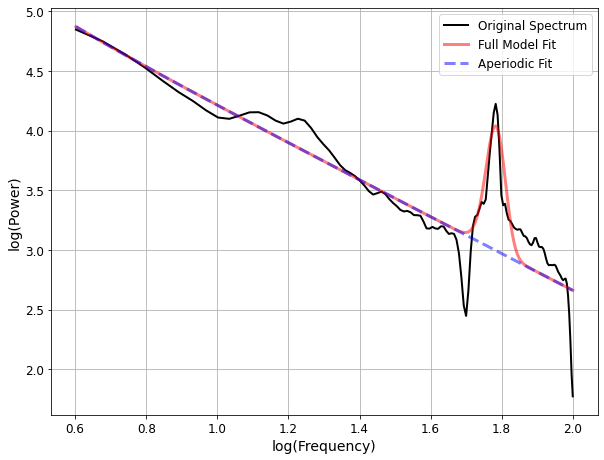

In [14]:
# Extract this model fit from the group
for idx in low_r_squared:
    sm = sgm_pre.get_model(idx, regenerate=True)

    # Check results and visualize the extracted model
    sm.print_results()
    sm.plot(plt_log=True)

#### Calculating max error psd

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 4 - 100 Hz                        
                                 Frequency Resolution is 0.76 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.2951, 2216.8748, 2.9984                                     
                                                                                                  
                                       1 peaks were found:                                        
          

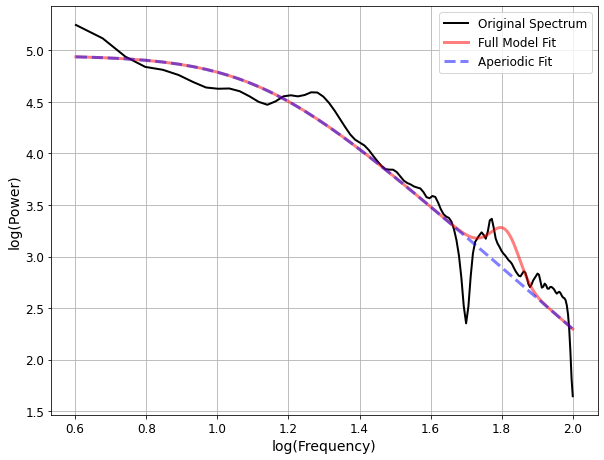

In [15]:
# Find the index of the worst model fit from the group
worst_fit_ind = np.argmax(sgm_pre.get_params('error'))

# Extract this model fit from the group
fm = sgm_pre.get_model(worst_fit_ind, regenerate=True)

# print report
fm.report(plt_log=True)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 4 - 101 Hz                        
                                 Frequency Resolution is 0.76 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     5.7393, -1.0806, 1.5390                                      
                                                                                                  
                                       1 peaks were found:                                        
          

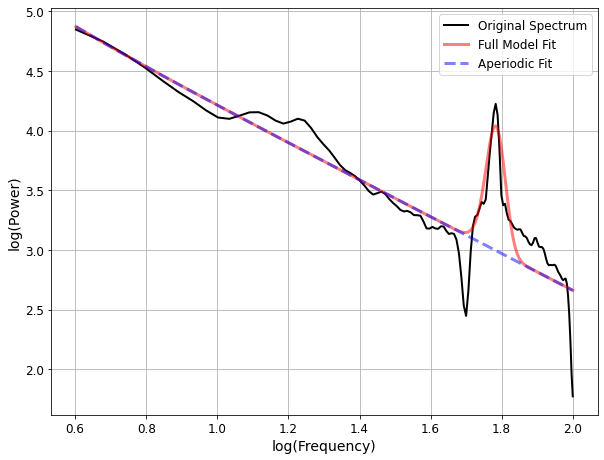

In [19]:
# re-fit and compare

# fit model with same settings and data
fm_refit = SpectralModel(*sm.get_settings())
fm_refit.report(sm.freqs, 10**sm.power_spectrum, fm.freq_range, plt_log=True)


## Explore fits which have peaks at the width limits

In [20]:
df_spec = pd.read_csv(f"{EXTERNAL_PATH}/data/results/lfp_spectral_params.csv", index_col=0)
df_spec

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,A_SNR_041018,0,0,1,pre.npz,7.604253,1.293679e+02,2.757998,NaN,NaN,NaN,NaN,NaN,NaN,60.976525,0.285674,6.977532,0.100041,0.975871
1,A_SNR_041018,1,1,1,pre.npz,8.064977,8.374157e+02,3.111327,NaN,NaN,NaN,NaN,NaN,NaN,61.256158,0.314370,8.050263,0.079992,0.981672
2,A_SNR_041018,2,2,1,pre.npz,7.729951,4.938553e+02,2.955929,NaN,NaN,NaN,NaN,NaN,NaN,65.184953,0.394152,12.000000,0.126104,0.960045
3,A_SNR_041018,3,3,1,pre.npz,8.185744,1.720534e+03,3.273690,NaN,NaN,NaN,NaN,NaN,NaN,87.339929,0.447514,12.000000,0.100416,0.974426
4,A_SNR_041018,4,4,1,pre.npz,7.728902,3.818995e+02,2.986966,NaN,NaN,NaN,NaN,NaN,NaN,64.296267,0.339042,12.000000,0.113804,0.969723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,L_SNR_250717,59,1019,16,post.npz,9.885466,1.100355e+05,4.154465,NaN,NaN,NaN,NaN,NaN,NaN,59.070810,1.134303,6.806784,0.160028,0.906224
6140,L_SNR_250717,60,1020,16,post.npz,10.135661,1.678743e+05,4.219263,NaN,NaN,NaN,NaN,NaN,NaN,58.978639,1.067226,7.111739,0.167929,0.896352
6141,L_SNR_250717,61,1021,16,post.npz,10.986258,1.174661e+06,4.718390,NaN,NaN,NaN,NaN,NaN,NaN,58.636381,1.159687,7.542390,0.186860,0.894020
6142,L_SNR_250717,62,1022,16,post.npz,8.470206,1.755064e+03,3.055510,NaN,NaN,NaN,NaN,NaN,NaN,63.647632,0.776873,12.000000,0.243161,0.837688


In [22]:
df = df_spec[df_spec['bw_1']==20]
plt.hist(df['cf_1'])
df.tail()

In [18]:
# load example data
fname = r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_psd\A_SNR_041018\NSP8_array15_LFP_pre.npz"
data_in = np.load(fname)
print(data_in.files)
spectra = data_in['spectra']
freq = data_in['freq']
print(spectra.shape)
print(freq.shape)

# compute mean across trials
spectra_mean = np.mean(spectra, axis=0)
print(spectra_mean.shape)

['spectra', 'freq']
(102, 64, 76)
(76,)
(64, 76)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 97 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.1591, 3513.8394, 3.0844                                     
                                                                                                  
                                       1 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 97 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    9.1745, 75613.5482, 3.8038                                    
                                                                                                  
                                       2 peaks were found:                                        
          

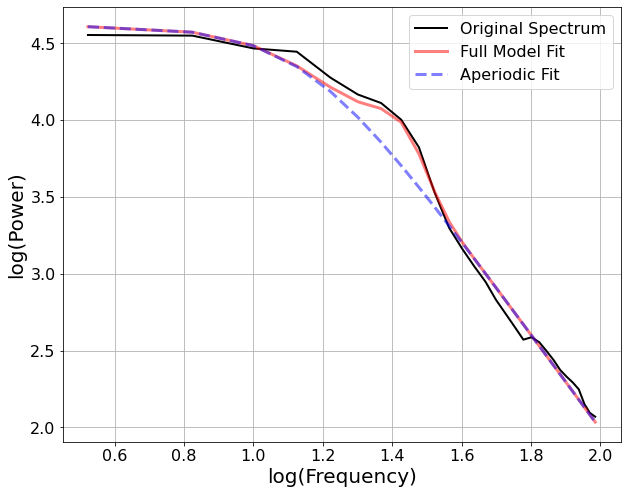

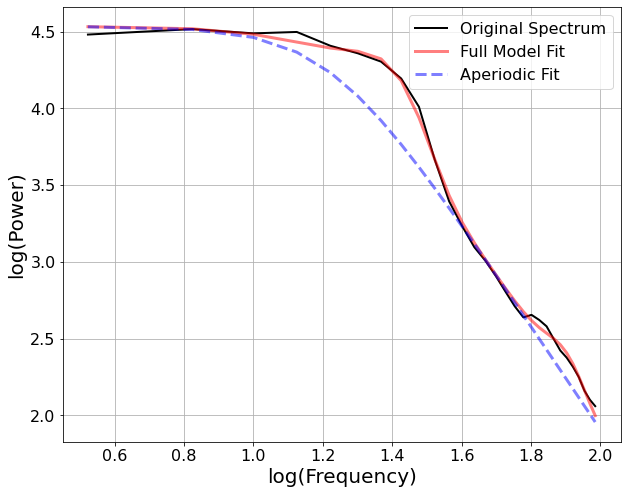

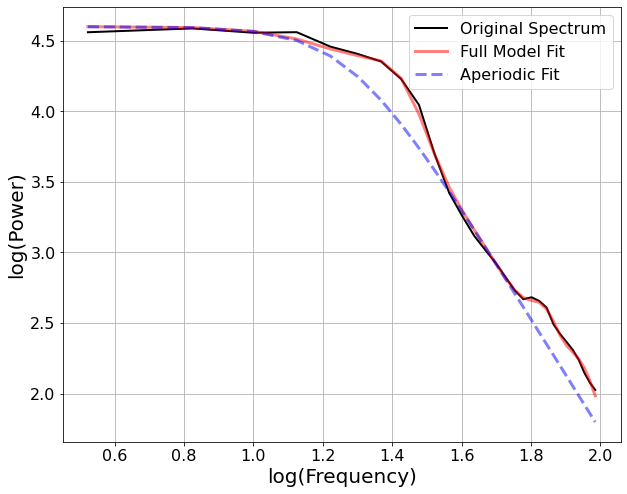

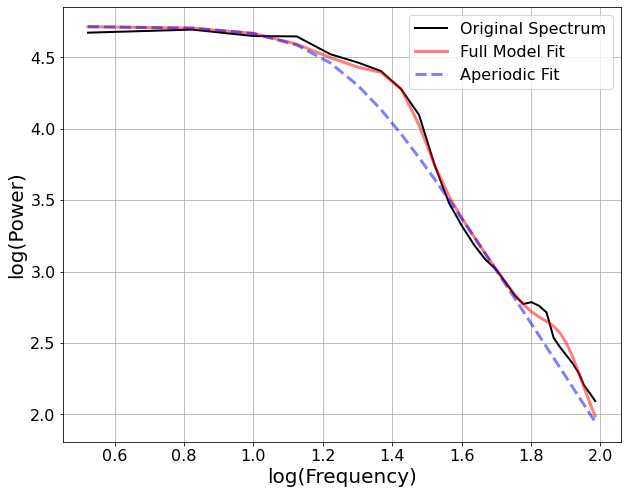

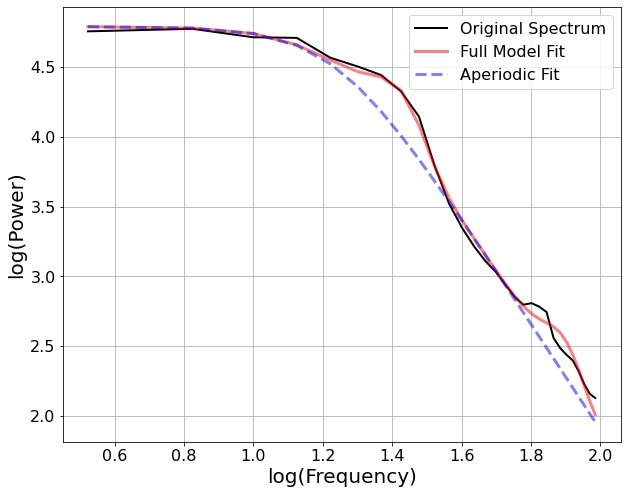

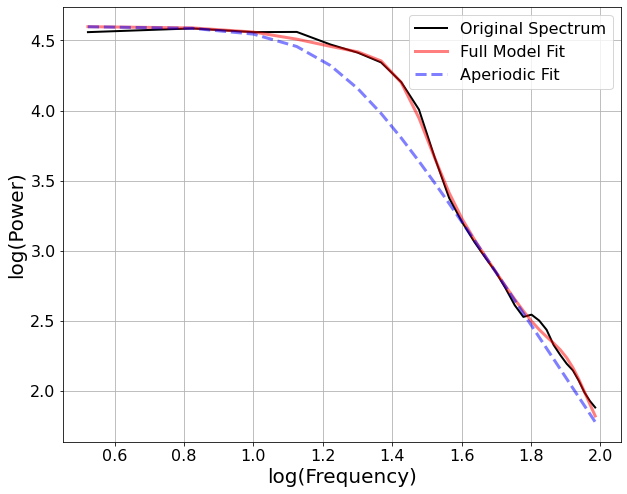

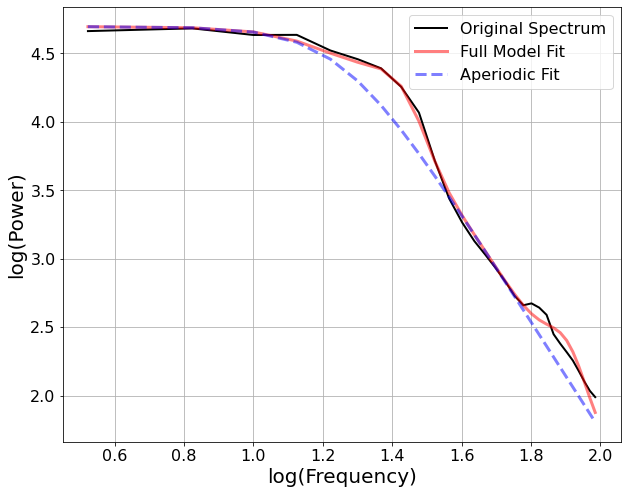

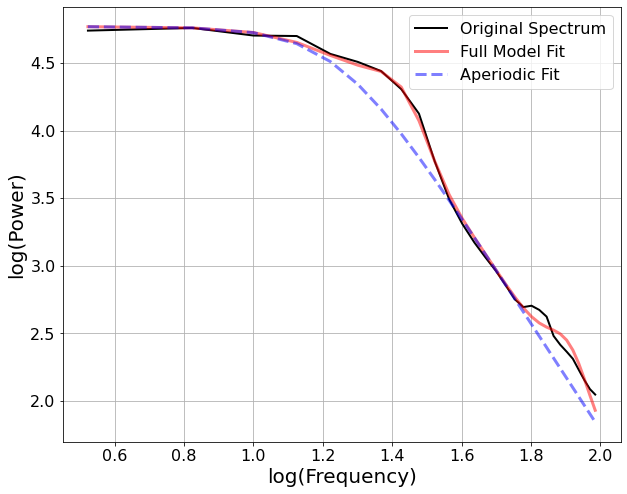

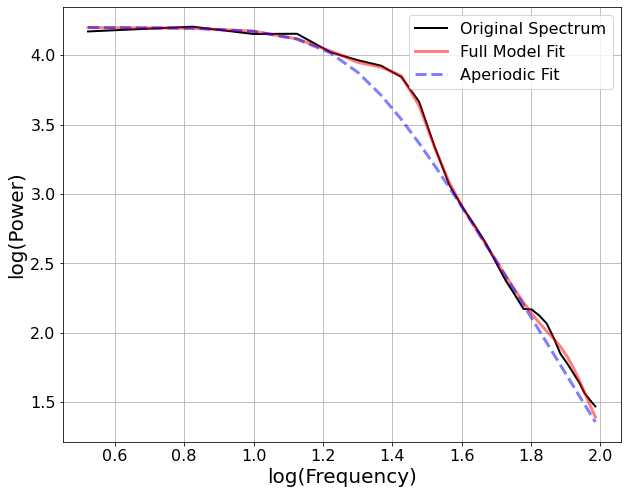

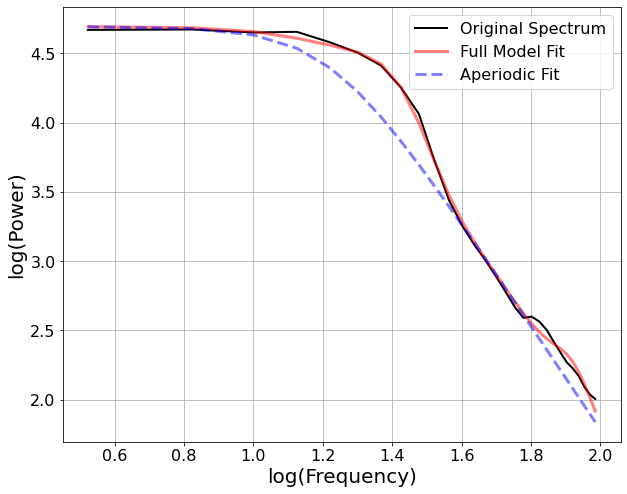

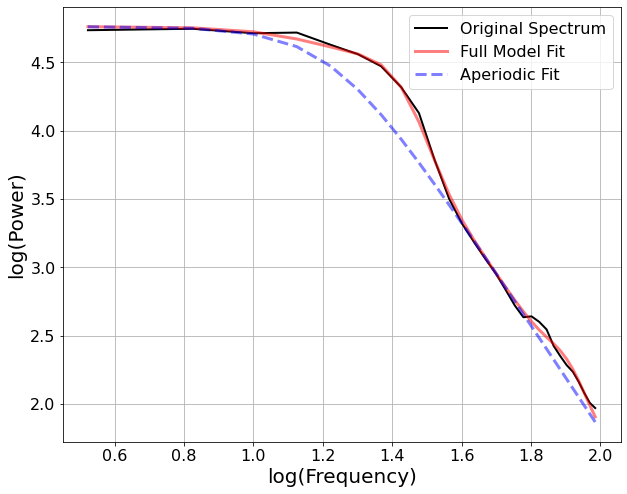

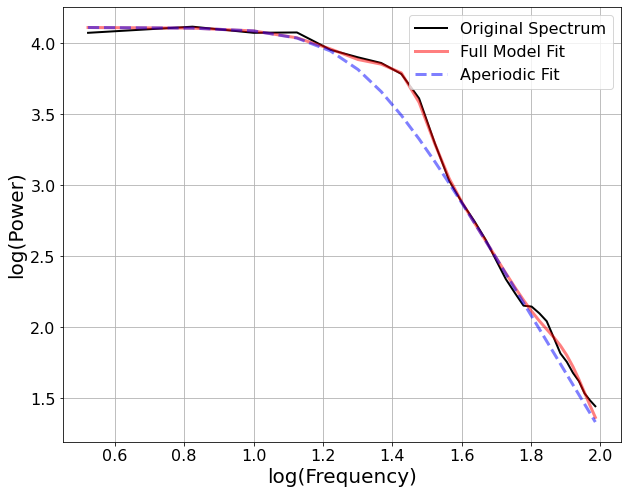

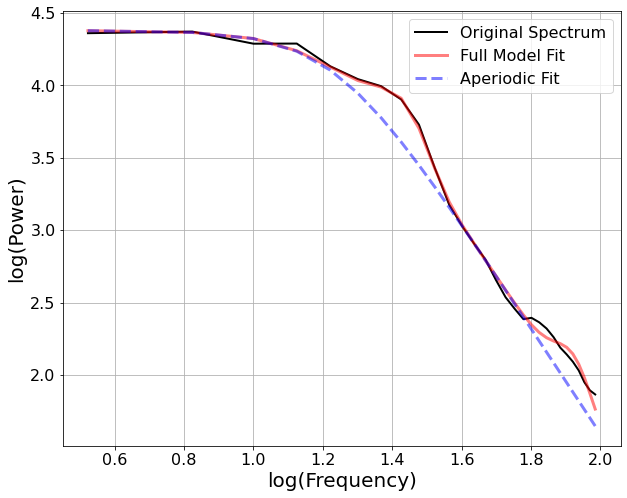

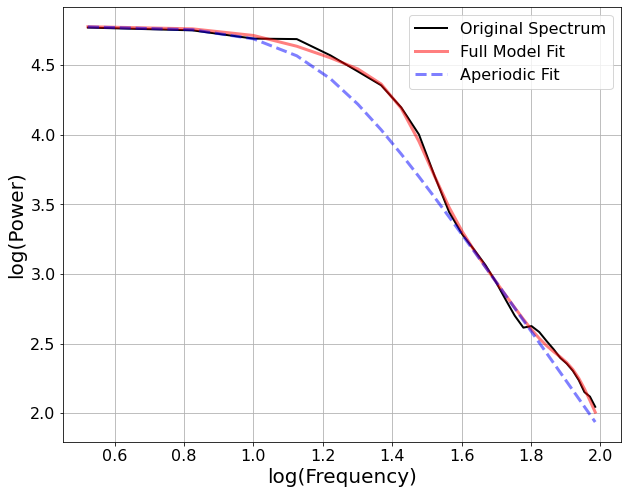

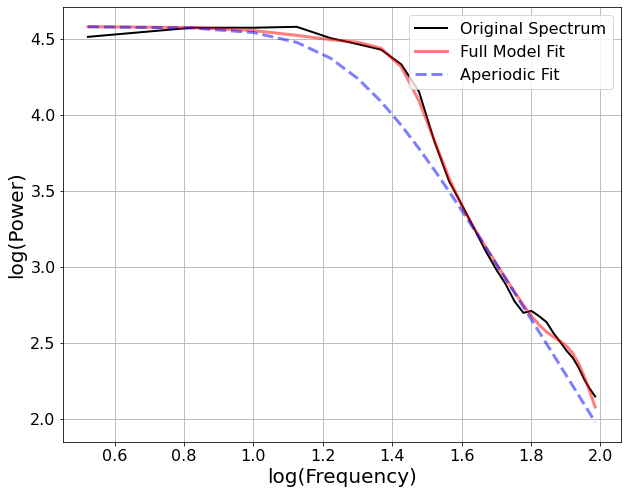

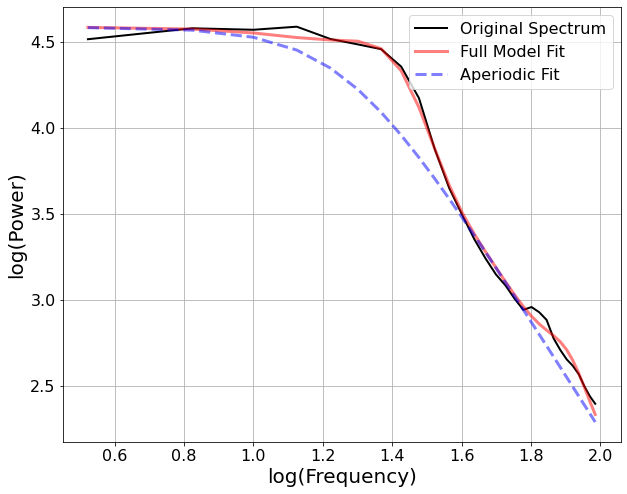

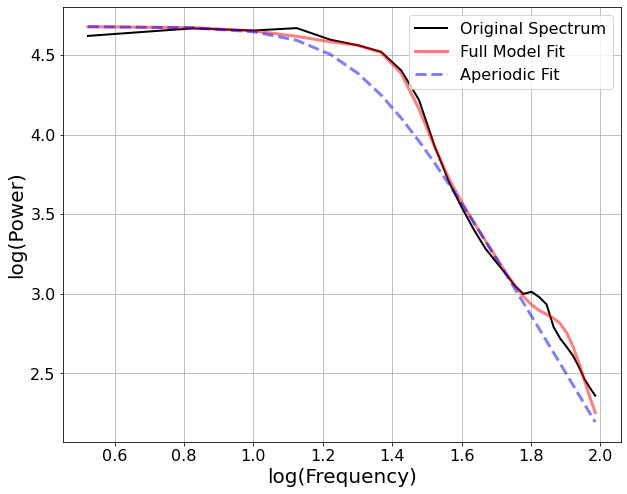

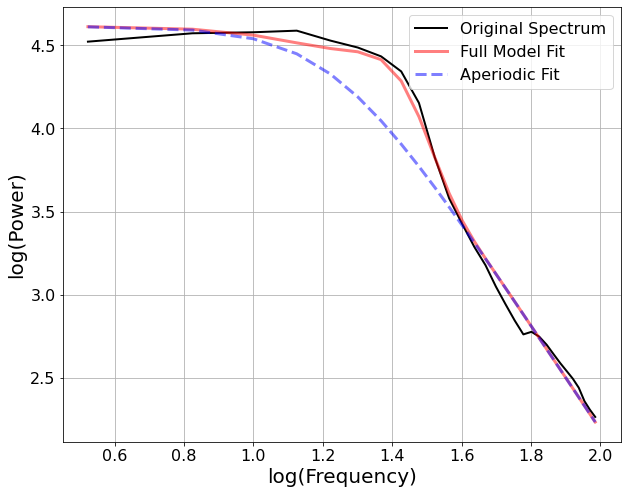

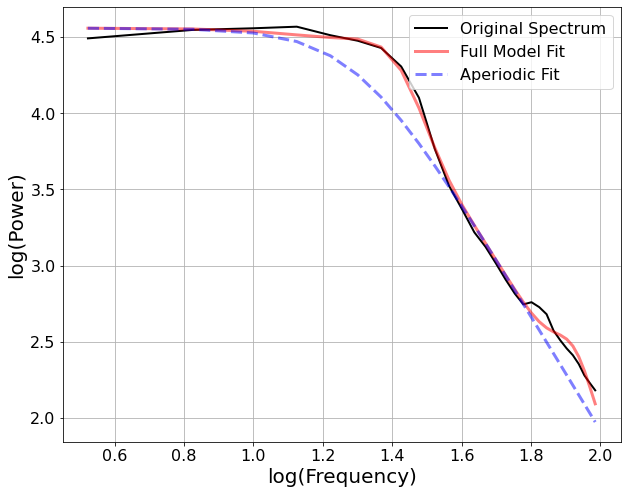

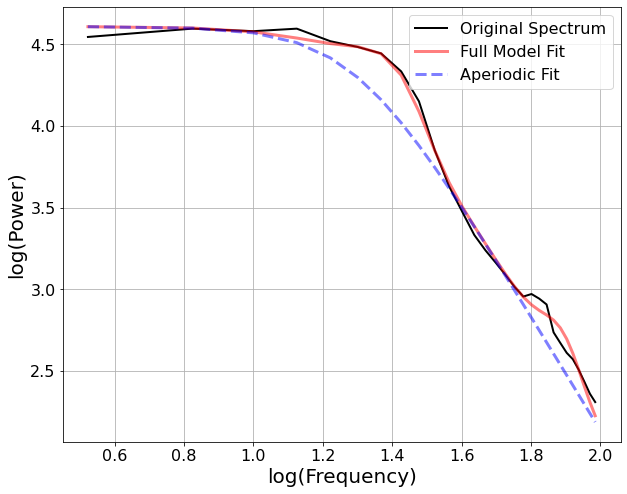

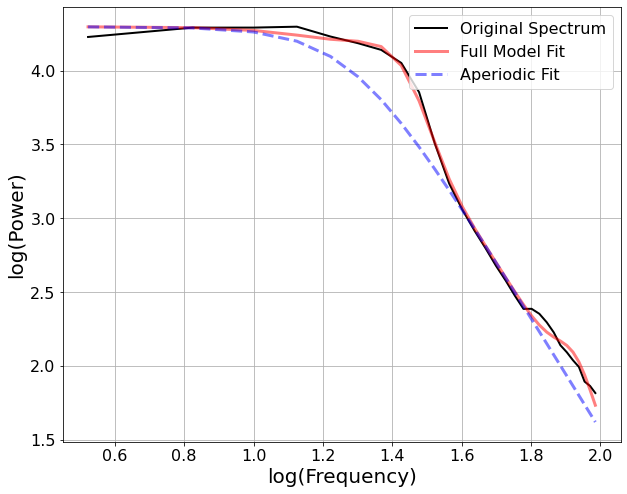

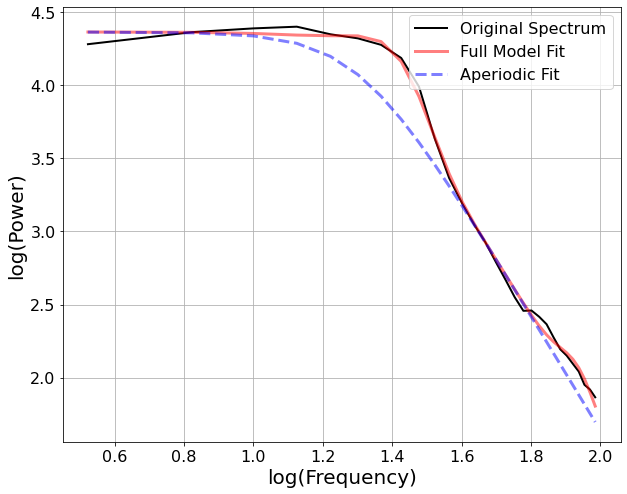

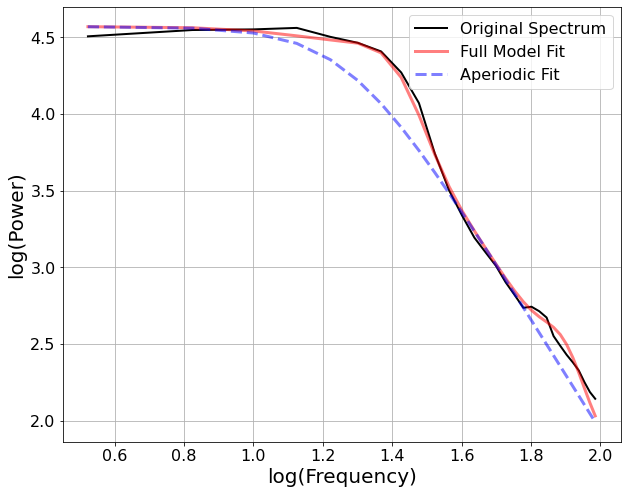

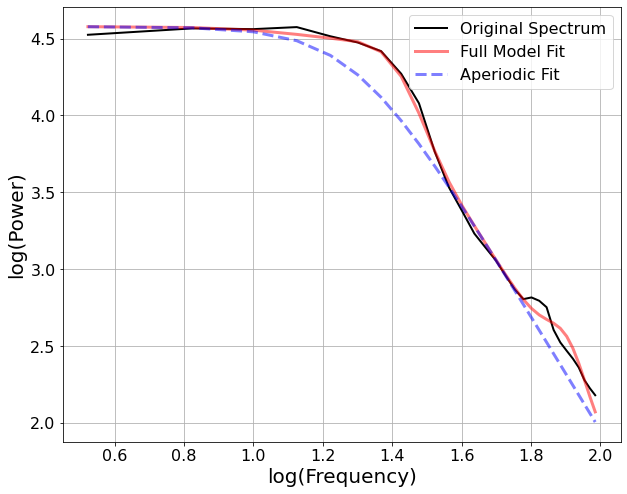

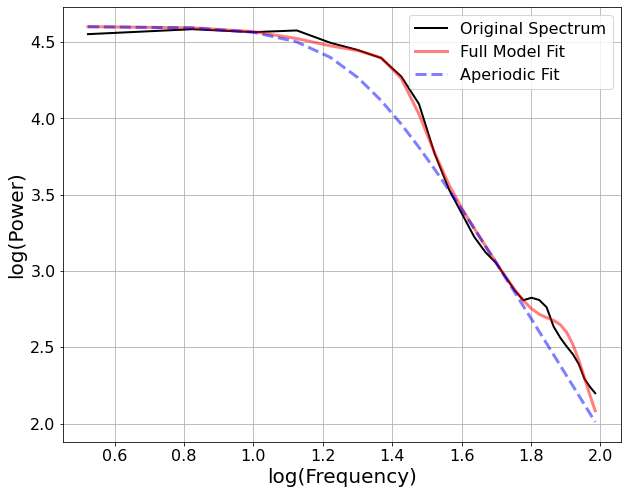

In [33]:
# plot spectral fit (0-100 frequency range as used in pipeline)

# set frequency range
freq_idx = (freq>0) & (freq<100)

# # plot each channel separately
# for i_chan in range(spectra_mean.shape[0]):
#     plot_spectrum(freq[freq_idx], spectra_mean[i_chan, freq_idx], log_freqs=True, log_powers=True)

# plot fit for select channels
chan_idx = df.loc[(df['session']=='A_SNR_041018') & (df['array']==15) & (df['epoch']=='pre'), 'channel'].values.astype(int)
for i_chan in chan_idx:
    model = FOOOF(**SPEC_PARAM_SETTINGS)
    model.report(freq[freq_idx], spectra_mean[i_chan, freq_idx], plt_log=True)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 250 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    9.4581, 84003.5464, 3.8823                                    
                                                                                                  
                                       3 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 250 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                   9.7442, 242756.8291, 4.0627                                    
                                                                                                  
                                       4 peaks were found:                                        
          

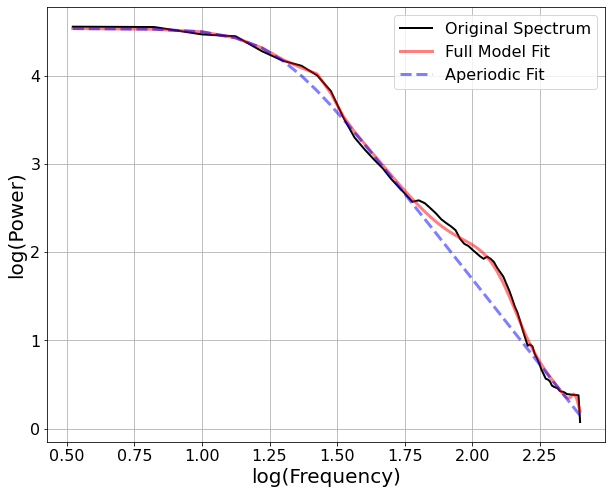

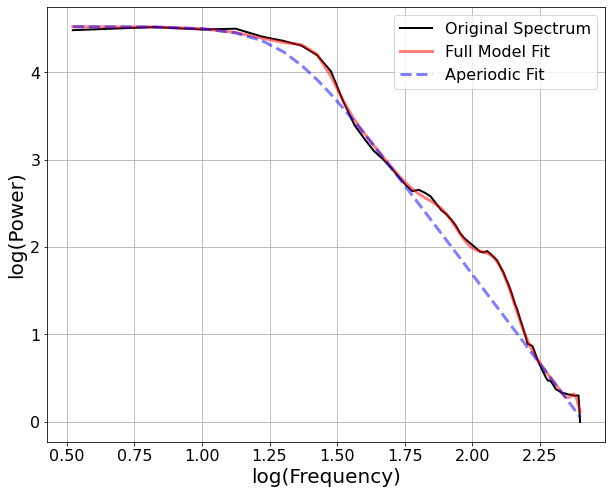

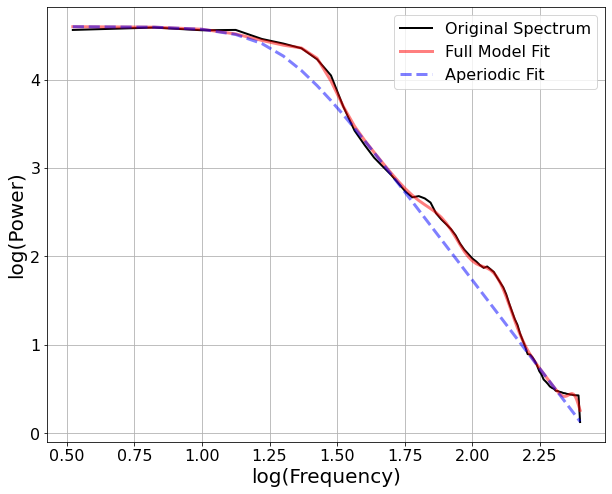

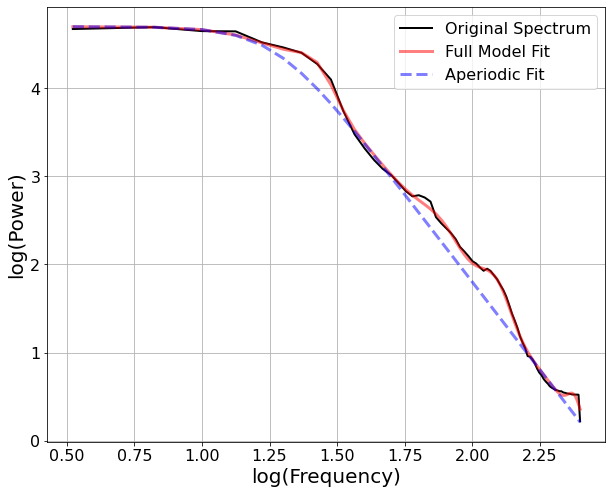

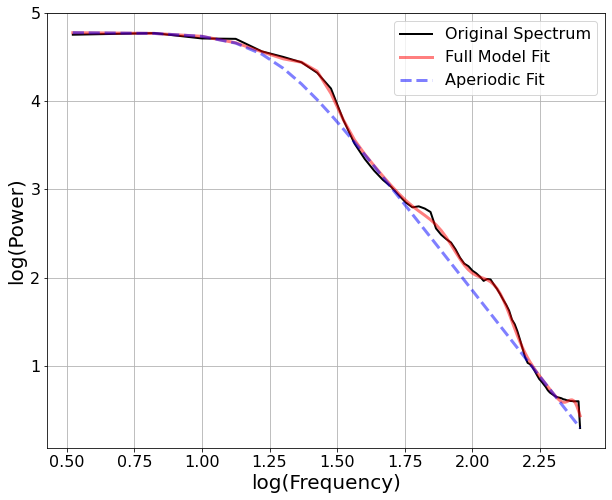

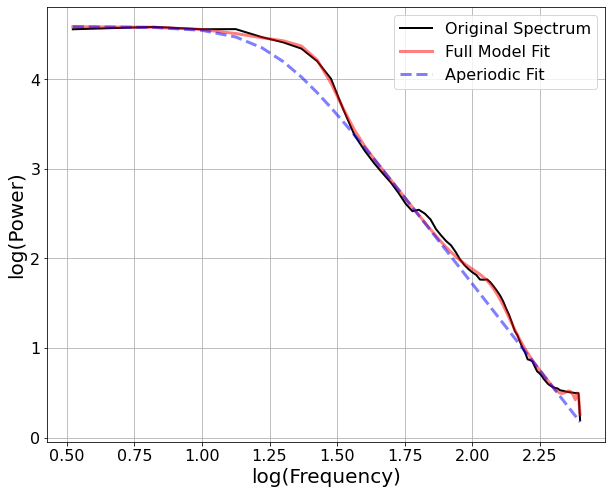

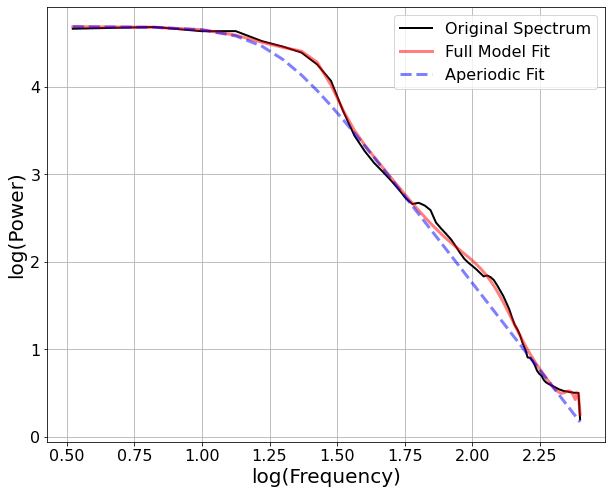

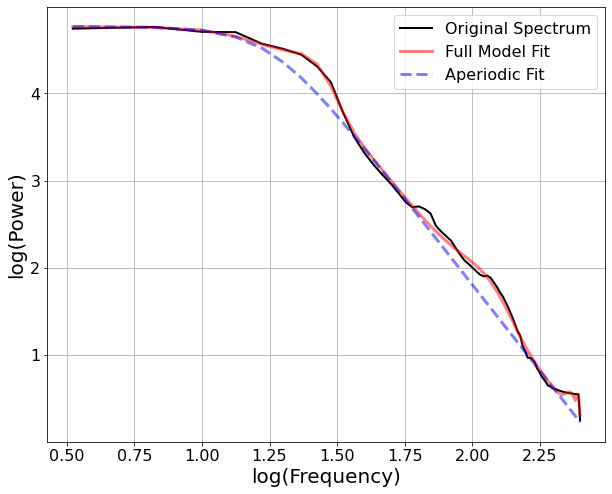

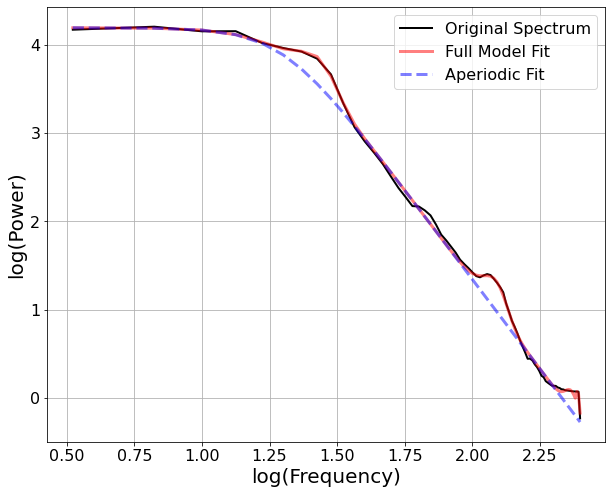

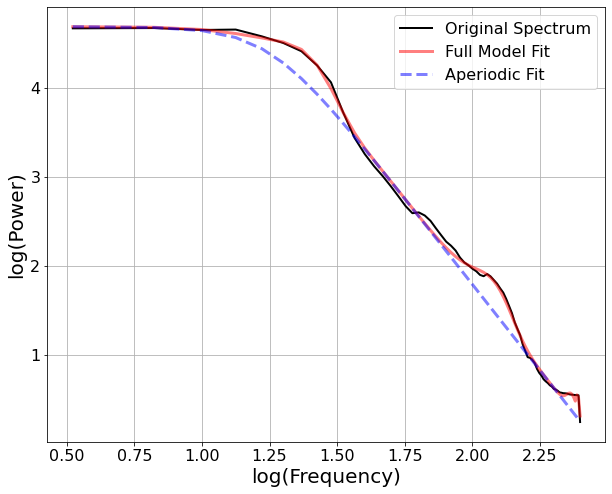

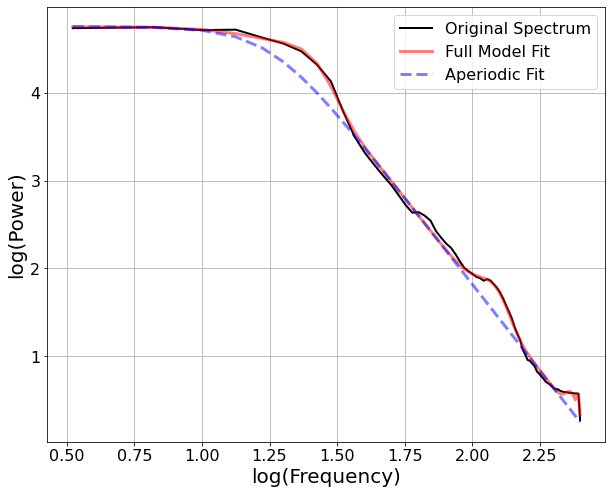

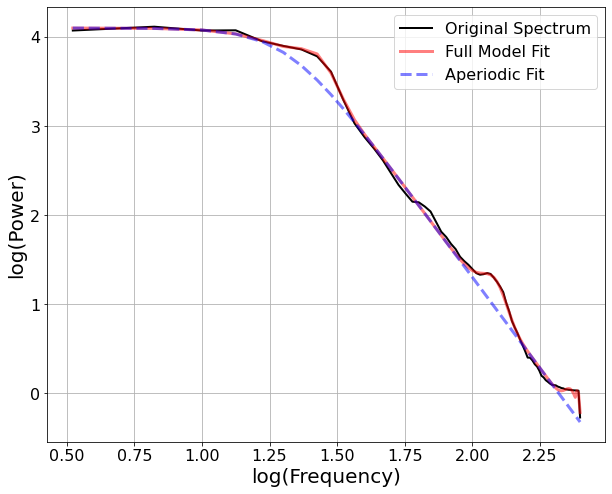

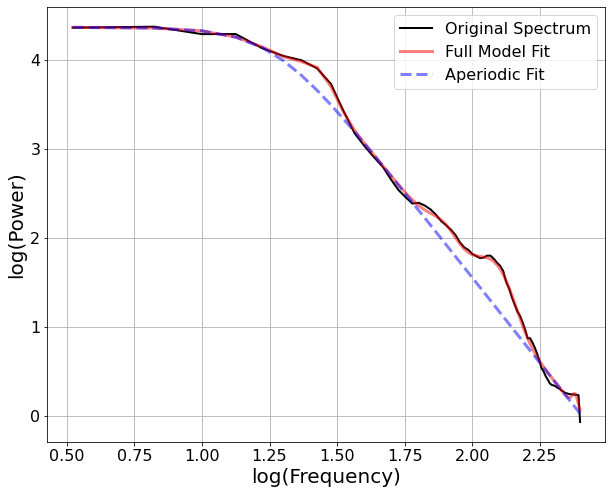

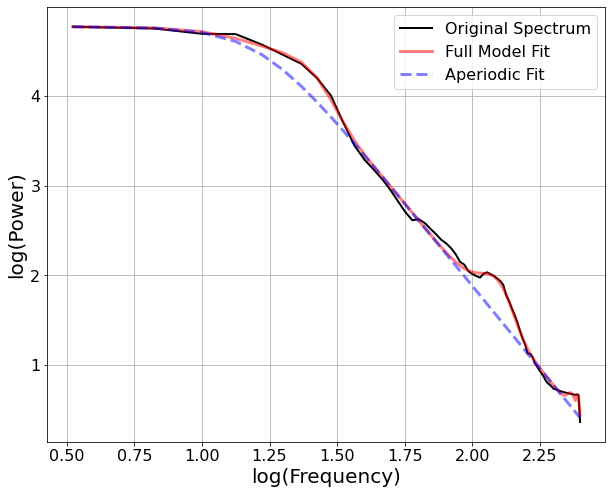

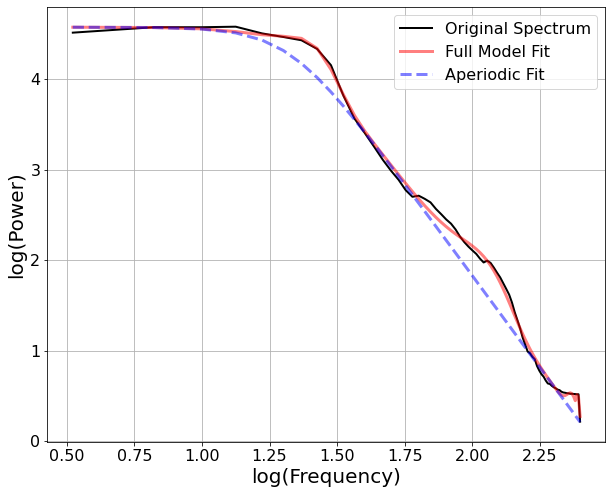

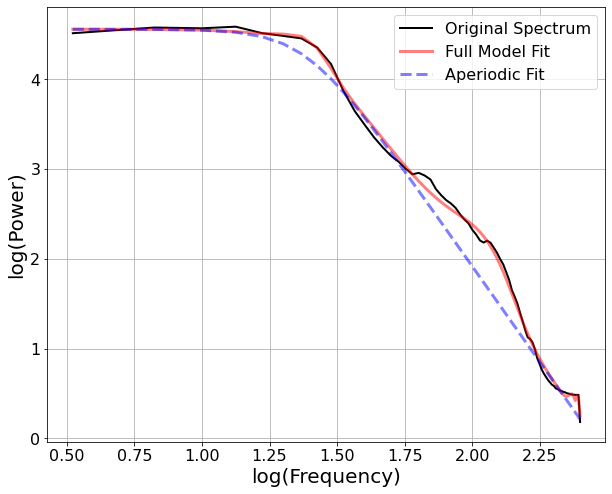

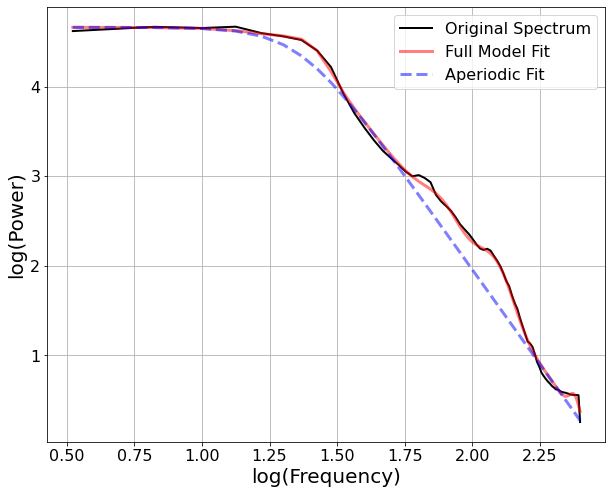

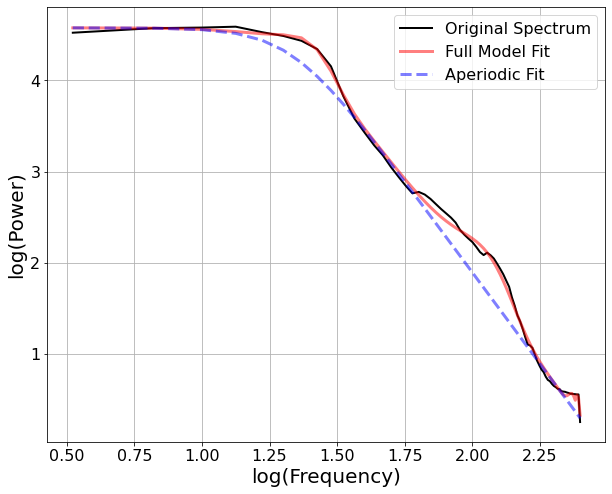

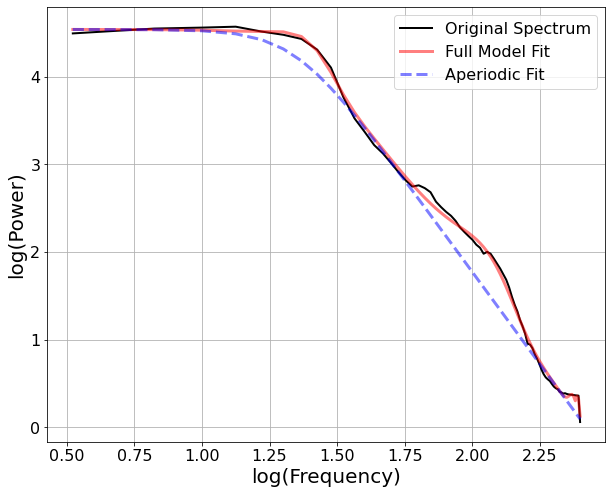

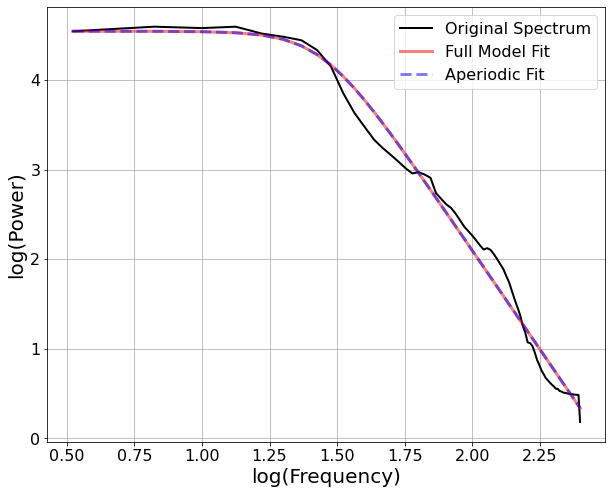

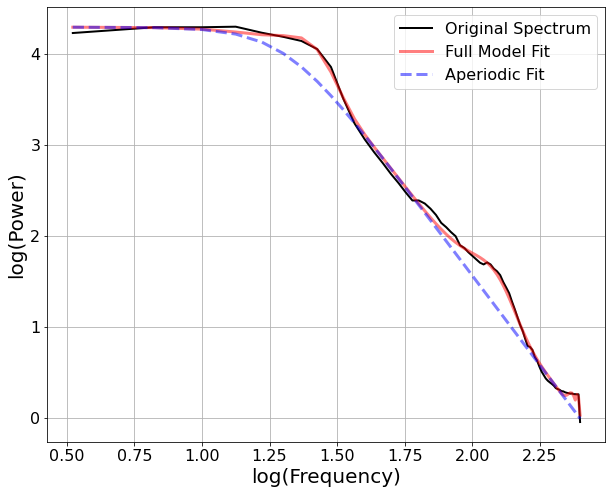

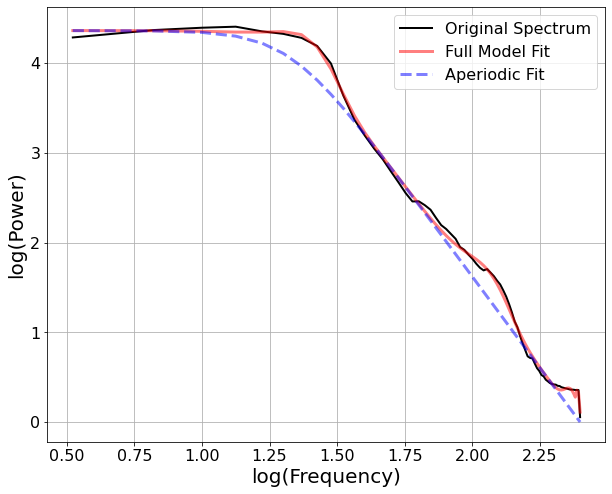

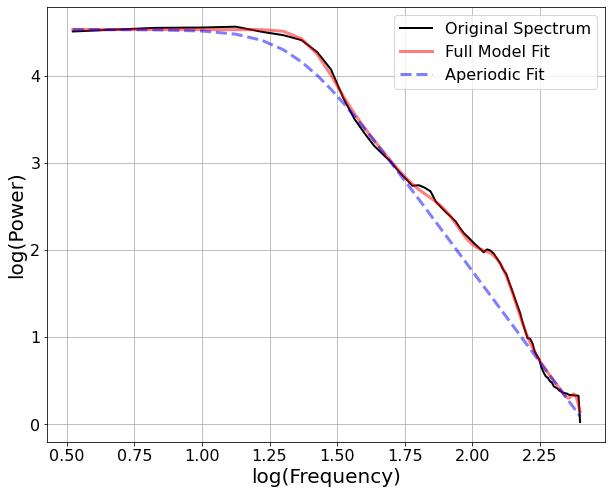

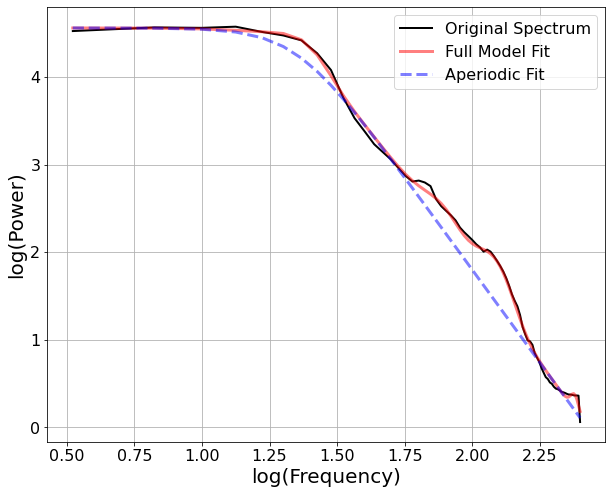

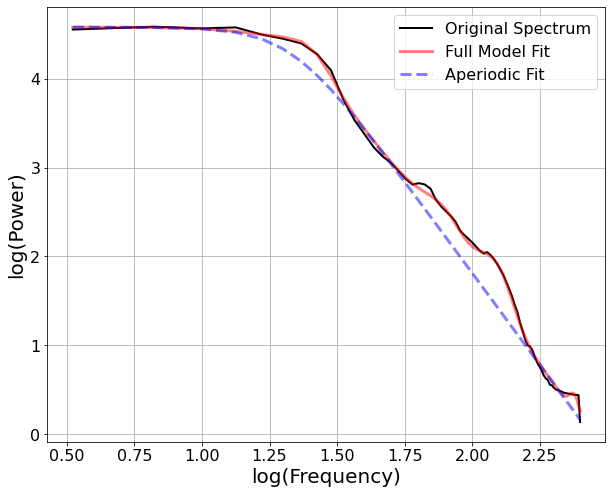

In [22]:
# plot specparam report for example data - no frequency range specified

# # plot each channel separately
# for i_chan in range(spectra_mean.shape[0]):
#     plot_spectrum(freq[freq_idx], spectra_mean[i_chan, freq_idx], log_freqs=True, log_powers=True)

# plot fit for select channels
chan_idx = df.loc[(df['session']=='A_SNR_041018') & (df['array']==15) & (df['epoch']=='pre'), 'channel'].values.astype(int)
for i_chan in chan_idx:
    model = FOOOF(**SPEC_PARAM_SETTINGS)
    model.report(freq, spectra_mean[i_chan], plt_log=True)


It looks like some high-frequency peaks are genuinely broader than 20 Hz, so it may be best to increase the upper width limit... This preview has also revealed that peaks are being fit to what we would typically consider to be the spectral knee, which is non-optimal.

## Investigate single-trial fits

Some of the power spectra are unusually shaped and the spectral fits are non-optimal. Broad peaks in the trial-averaged power spectra may reflect variability in the peak frequency of an oscillation between trials (particularly in the high-frequency range). 

In [27]:
# load example spectral results
fname = f"{EXTERNAL_PATH}/data/lfp/lfp_spectra/{SESSIONS[0]}_spectra.npz"
data_in = np.load(fname)
spectra = data_in['spectra_pre']
freq = data_in['freq']
print(f"spectra shape: \t{spectra.shape}")
print(f"freq shape: \t{freq.shape}")

spectra shape: 	(102, 1024, 76)
freq shape: 	(76,)


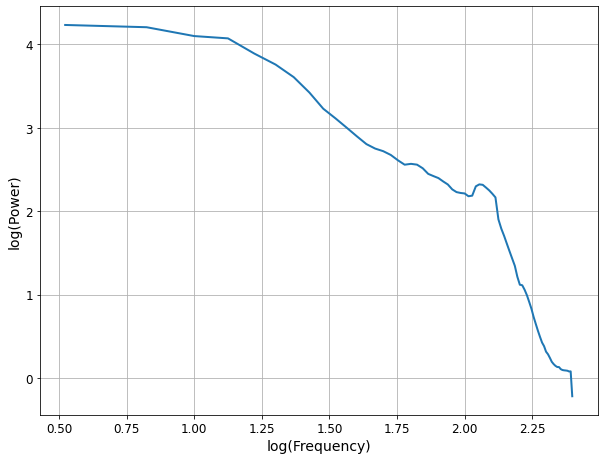

In [28]:
# plot trial-averaged spectra
i_chan = 960
plot_spectra(freq, np.mean(spectra[:, i_chan], axis=0), log_freqs=True, log_powers=True)

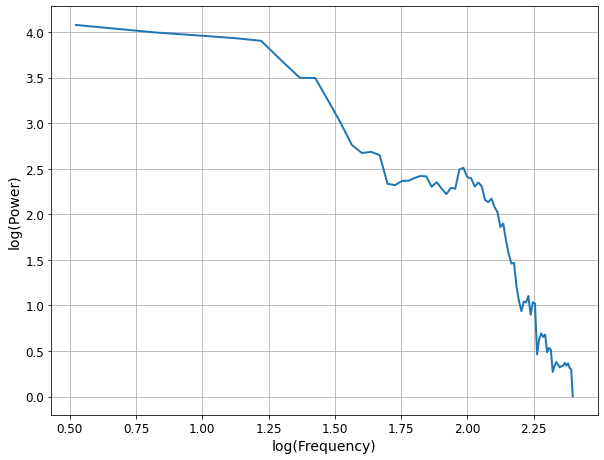

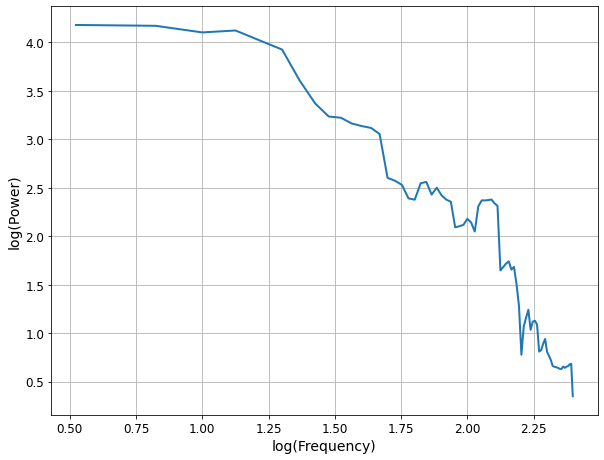

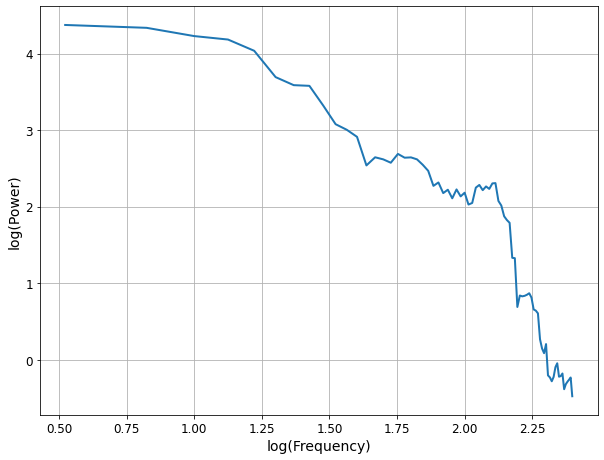

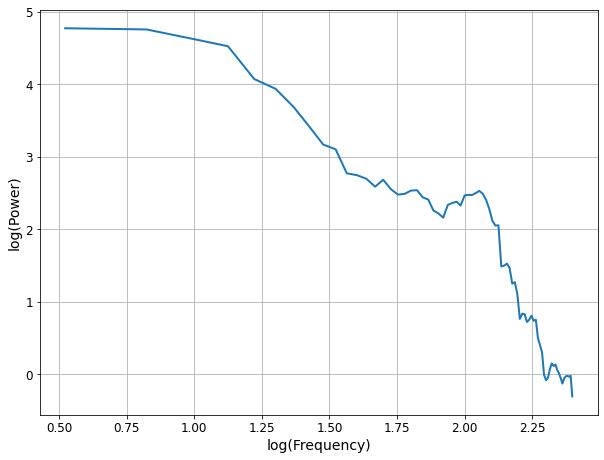

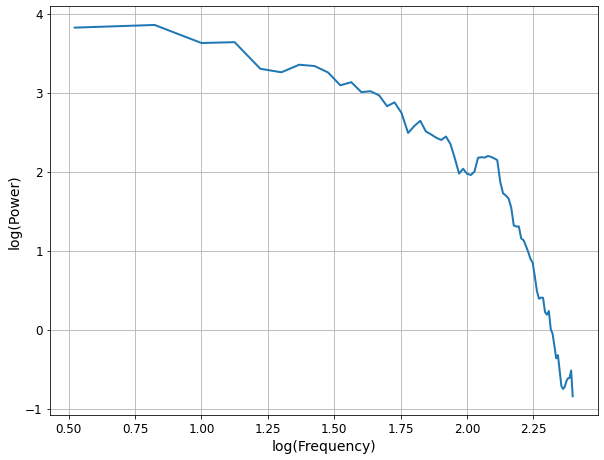

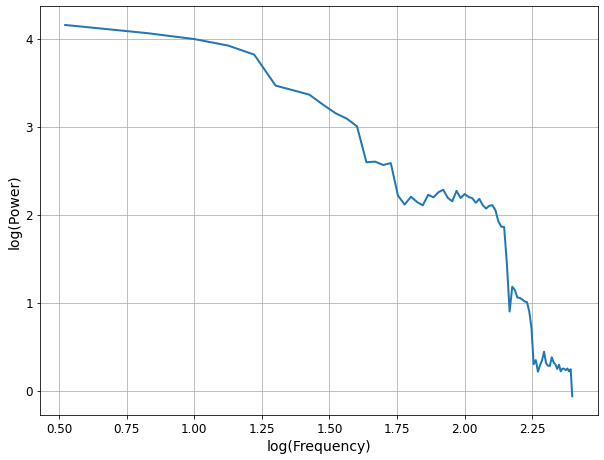

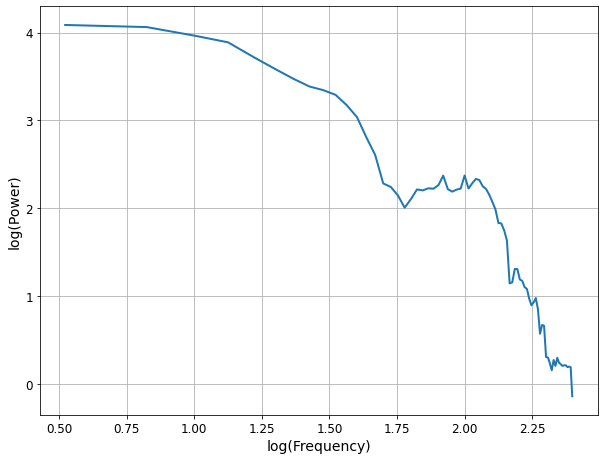

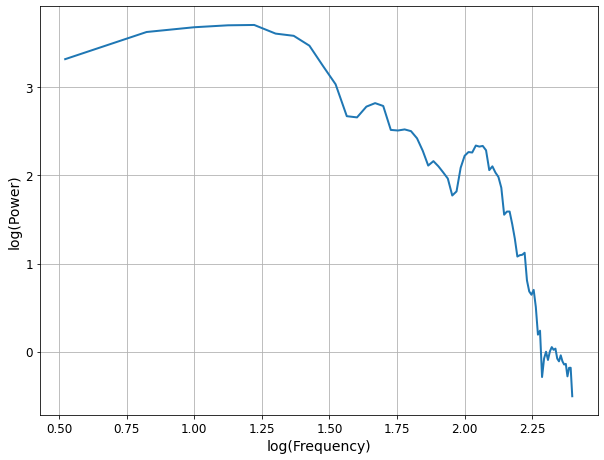

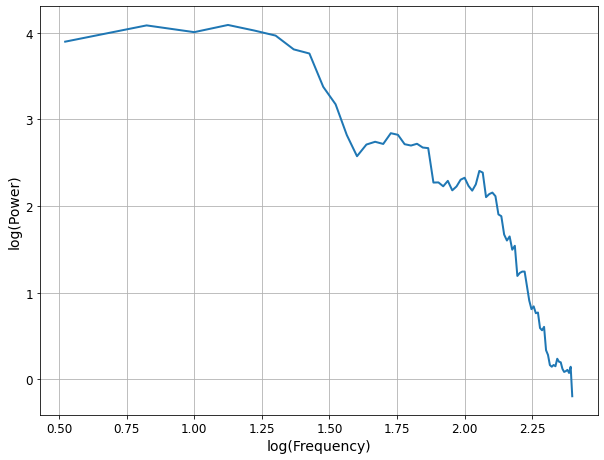

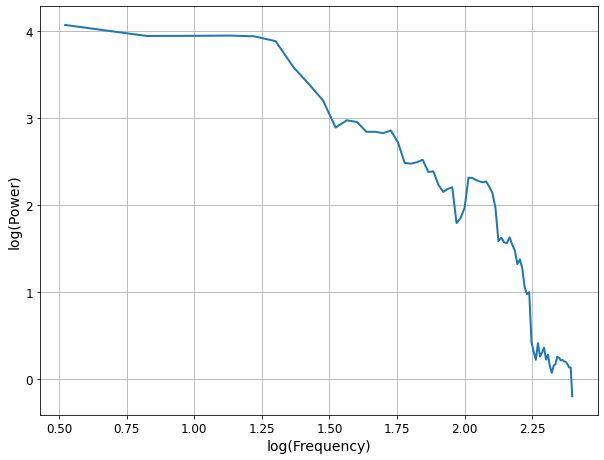

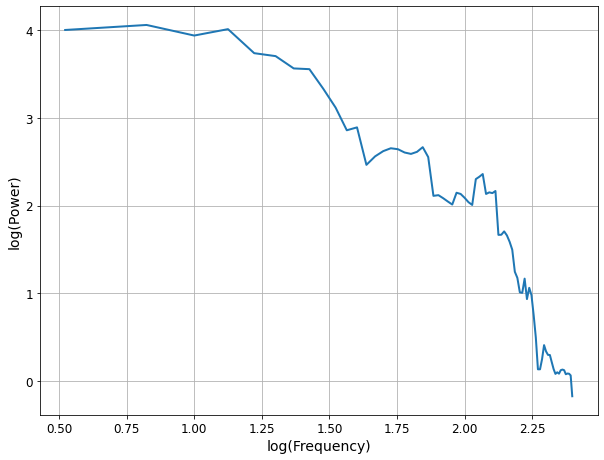

In [29]:
# plot single-trial spectra
i_chan = 960
for i_trial in range(0, spectra.shape[0], 10):
    plot_spectra(freq[1:], spectra[i_trial, i_chan, 1:], log_freqs=True, log_powers=True)

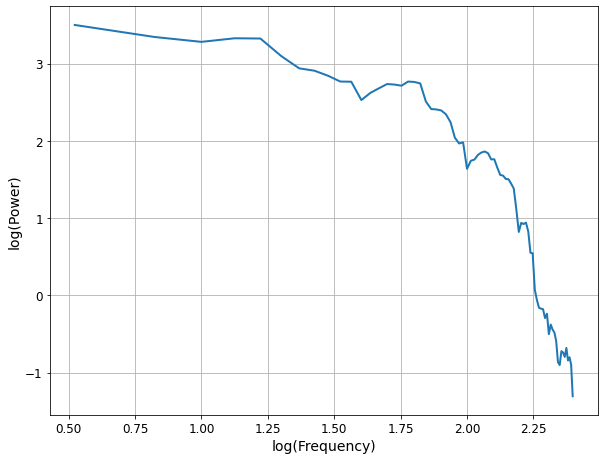

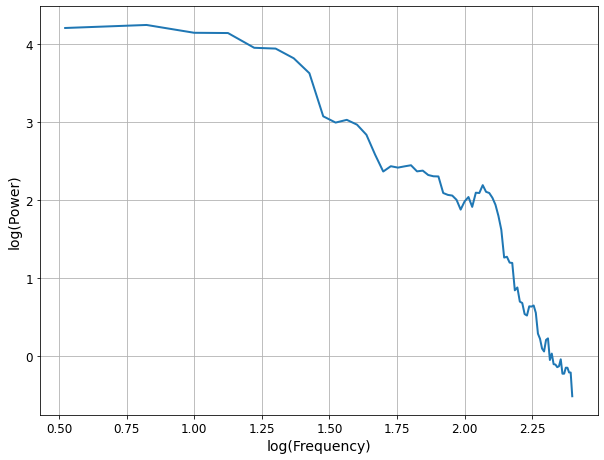

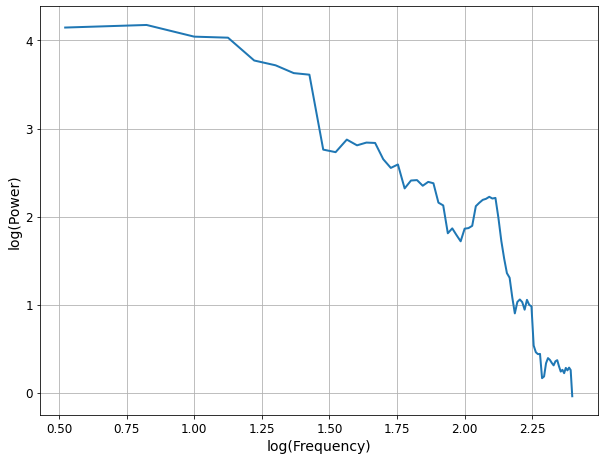

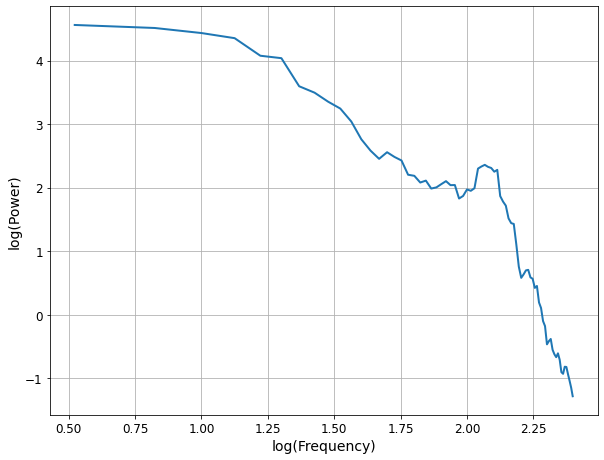

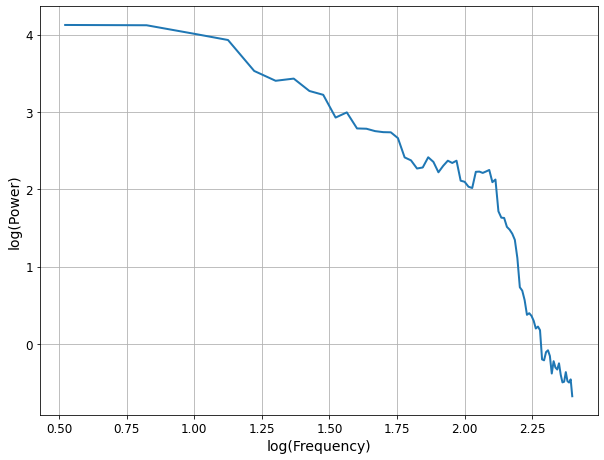

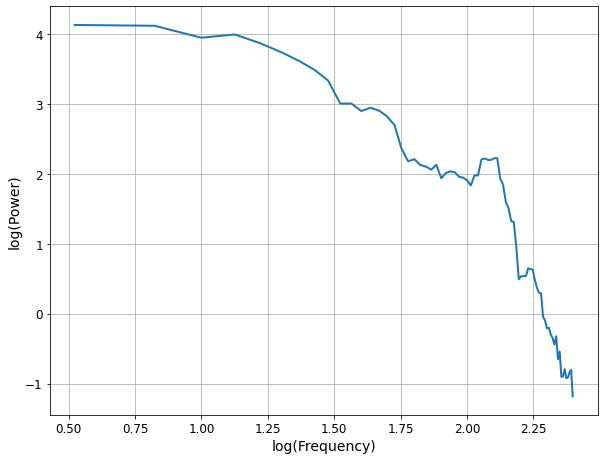

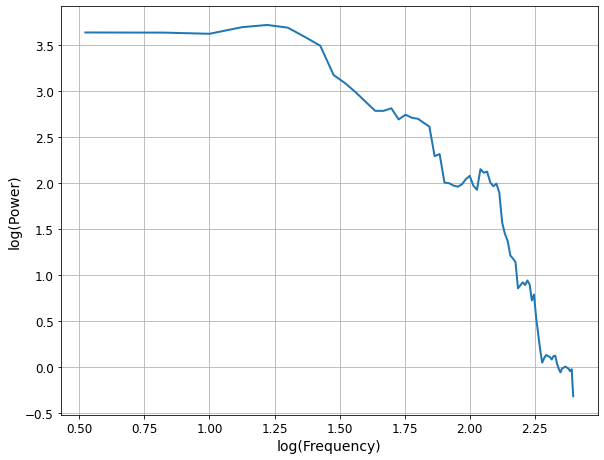

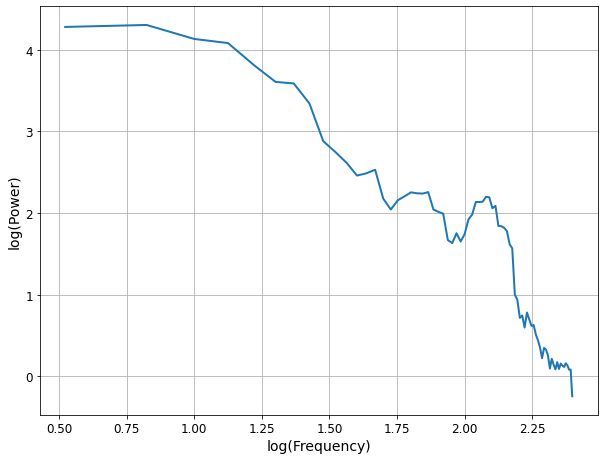

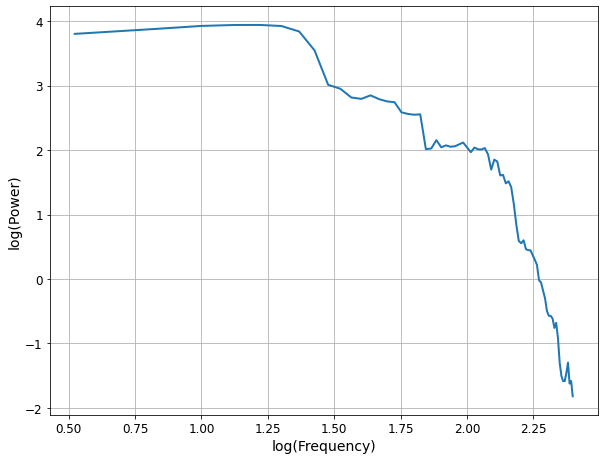

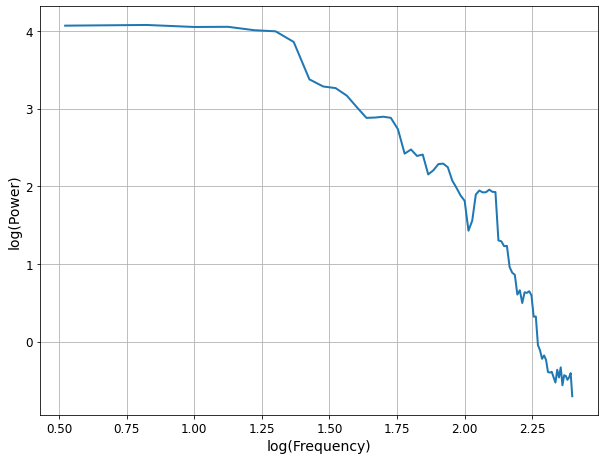

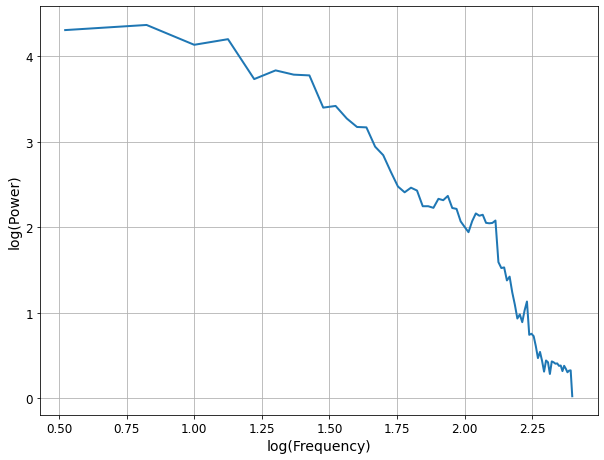

In [30]:
# plot single-trial spectra for another channel
i_chan = 965
for i_trial in range(0, spectra.shape[0], 10):
    plot_spectra(freq[1:], spectra[i_trial, i_chan, 1:], log_freqs=True, log_powers=True)

There appears to be a lot of variability between trials. There are trials with a single clear peak (at variable frequencies), 2 clear peaks, and those with broad power above the aperiodic. Furthermore, there are clear spectral peaks above 100 Hz (the upper limit of our fitting range)